In [1]:
from envs.grid.grid_3_actions import Grid
from envs.grid.policy_grid import ForwardPolicy, BackwardPolicy

from gflownet.gflownet import GFlowNet
from gflownet.utils import trajectory_balance_loss

from torch.optim import AdamW, Adagrad, Adam, SGD, RMSprop
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.nn.functional import one_hot
import torch
import matplotlib.pyplot as plt

import time

To train the model, construct an NxD matrix of initial states, where N is the desired number of samples and D is the dimensionality of the state vector (i.e. `state_dim`). Then, draw samples from the model using the `sample_states` method, giving it the initial states and setting `return_log=True`. The resulting `Log` object contains information about the trajectory of each sample, which is used to compute the trajectory balance loss.

In [2]:
def train (device, model, opt, opt_args, num_epochs, batch_size) :
  print ("Training the model on ", device)
  #compute the time taken to train the model
  time_in = time.time()
  model = model.to(device)
  
  opt = opt(model.parameters(), **opt_args)
  scheduler = CosineAnnealingWarmRestarts(opt, T_0=10, T_mult=2)
  for i in range(num_epochs):
    s0 = one_hot(torch.zeros(batch_size).long(), model.env.state_dim).float().to(device)
    
    s, log = model.sample_states(s0, return_log=True)
    
    loss = trajectory_balance_loss(log.total_flow, log.rewards, log.fwd_probs, log.back_probs)
    loss.backward()
    
    opt.step()
    opt.zero_grad()
    
    scheduler.step(i)
    
    print("Epoch: ", i, "Loss: ", loss.item(), "Lr: ", scheduler.get_last_lr(), end='\r')
  print("Training complete ---------------------------")
  time_out = time.time() - time_in
  print("Time taken to train the model: ", time_out)
  
  return model

Finally, when the model has been trained, you can sample states using the same `sample_states(...)` method as before, this time without needing to supply the `return_log=True` argument.

In [3]:
def test(device, model, test_size, fig_name) :
    model = model.to(device)
    with torch.no_grad() : 
        s0 = one_hot(torch.zeros(test_size).long(), model.env.state_dim).float()
        s = model.sample_states(s0)
        
        grid_size = int(model.env.state_dim ** 0.5)

        figure = plt.figure()
        s_2d = s.reshape(-1,  grid_size, grid_size)
        s_2d = s_2d.mean(dim=0).reshape(grid_size, grid_size).numpy()

        f1 = figure.add_subplot(1, 2, 1)
        f1.set_title('Mean of ' + str(test_size) + ' samples')
        plt.imshow(s_2d)

        f2 = figure.add_subplot(1, 2, 2)
        f2.set_title('Optimal policy')
        plt.imshow(model.env.to_grid().reshape(grid_size, grid_size).numpy())
        
        plt.show()
        
        #save image to file
        figure.savefig(fig_name)


In [4]:
optimizers = [AdamW, Adagrad, Adam, SGD, RMSprop]
optimizer_args = [{'lr' : 1e-2}, {'lr' : 1e-2}, {'lr' : 1e-2}, {'lr' : 1e-2}, {'lr' : 1e-2}]
num_epochs = 1000
batch_size = 32
test_size = 10**4

grid_size = 16
hidden_dim = 32
env = Grid(size=grid_size)
backward_policy = BackwardPolicy(env.state_dim, num_actions=env.num_actions)
forward_policy = ForwardPolicy(env.state_dim, hidden_dim=hidden_dim, num_actions=env.num_actions)

Training the model on  cpu
Training complete ---------------------------.0038089217906910272]]
Time taken to train the model:  111.58741807937622


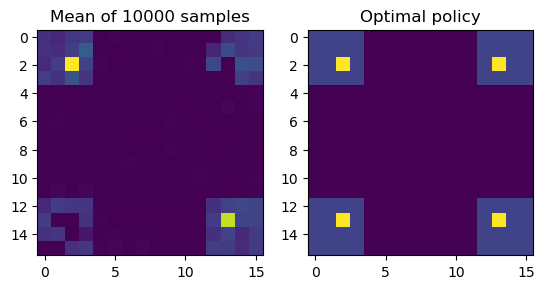

Training the model on  cpu
Training complete ---------------------------0038089217906910272]]]
Time taken to train the model:  112.45135569572449


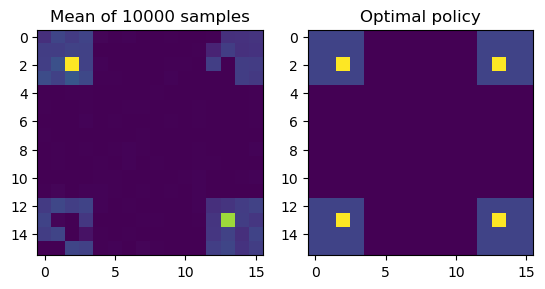

Training the model on  cpu
Training complete ---------------------------0038089217906910272]]]
Time taken to train the model:  114.34530997276306


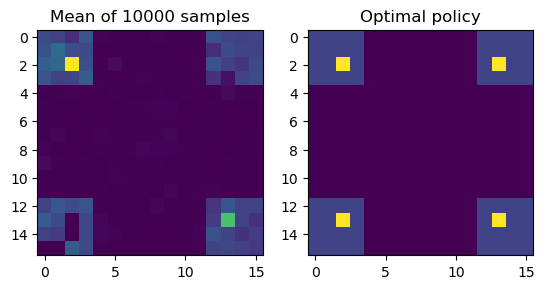

Training the model on  cpu
Training complete ---------------------------0038089217906910272]]]
Time taken to train the model:  111.7463550567627


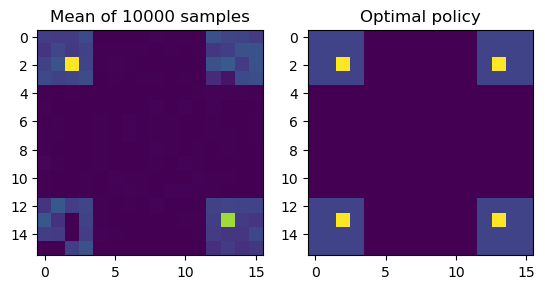

Training the model on  cpu
Training complete ---------------------------.0038089217906910272]]
Time taken to train the model:  114.49740719795227


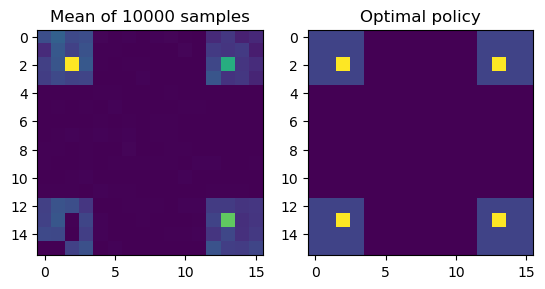

In [5]:
for i in range(len(optimizers)) :
    model = GFlowNet(forward_policy, backward_policy, env)

    model = train("cpu", model, optimizers[i], optimizer_args[i], num_epochs, batch_size)

    test("cpu", model, test_size, "test_" + optimizers[i].__name__ + ".png")